In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Collect RAVDESS DATA from Drive and expand the dimension for CNN

In [0]:
import numpy as np
ravdess_X = np.load('gdrive/My Drive/AI-Hackathon/ravdess_X.npy')
ravdess_y = np.load('gdrive/My Drive/AI-Hackathon/ravdess_y.npy')

In [0]:
ravdess_X = np.expand_dims(ravdess_X,axis=3)

Train-Test Seperation, Shuffling and Weight balance computation

In [0]:
from sklearn.model_selection import train_test_split
ravdess_train_X, ravdess_valid_X, ravdess_train_y, ravdess_valid_y  = train_test_split(ravdess_X,ravdess_y,test_size=0.2,random_state=42)

In [0]:
from sklearn.utils import shuffle
ravdess_train_X, ravdess_train_y = shuffle(ravdess_train_X, ravdess_train_y, random_state=42)

In [0]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(ravdess_train_y),ravdess_train_y)

Keras Sequential Model with 2D CNN and LSTM

In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LSTM, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import backend as K

model_ravdess = Sequential()
kernel = 5
model_ravdess.add(Conv2D(32, 5,strides=2,padding='same',
                 input_shape=(13,216,1)))
model_ravdess.add(Activation('relu'))
model_ravdess.add(BatchNormalization())

model_ravdess.add(Conv2D(64, 5,strides=2,padding='same',))
model_ravdess.add(Activation('relu'))
model_ravdess.add(BatchNormalization())

model_ravdess.add(Conv2D(64, 5,strides=2,padding='same',))
model_ravdess.add(Activation('relu'))
model_ravdess.add(BatchNormalization())
model_ravdess.add(MaxPooling2D(pool_size=(2,3)))
model_ravdess.add(Lambda(lambda x: K.squeeze(x, axis= 1)))

model_ravdess.add(LSTM(16))
model_ravdess.add(Dropout(0.2))

model_ravdess.add(Dense(7))
model_ravdess.add(Activation('softmax'))


opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [103]:
model_ravdess.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 7, 108, 32)        416       
_________________________________________________________________
activation_25 (Activation)   (None, 7, 108, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 108, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 54, 64)         24640     
_________________________________________________________________
activation_26 (Activation)   (None, 4, 54, 64)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 4, 54, 64)         256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 27, 64)        

In [0]:
model_ravdess.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
cnnhistory=model_ravdess.fit(ravdess_train_X, ravdess_train_y, batch_size=16, epochs=10, validation_data=[ravdess_valid_X,ravdess_valid_y])

In [0]:
model_ravdess.save('lstm_cnn_rectangular_low_dropout.h5')

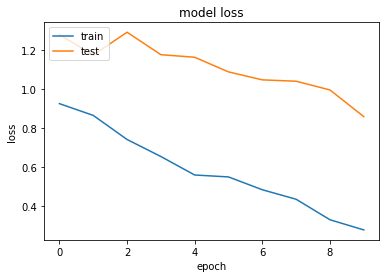

In [124]:
import matplotlib.pyplot as plt
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import os 
import librosa
i=0
test_labels = []
t_arr = np.zeros((30,13,216))
for folder in os.listdir('Tata-Training-Diarize'):
  for file in os.listdir(f'{"Tata-Training-Diarize/"}{folder}'):
    try:
      X, sample_rate = librosa.load(f'{"Tata-Training-Diarize/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
      sample_rate = np.array(sample_rate)
      mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

      result = np.zeros((13,216))
      result[:mfccs.shape[0],:mfccs.shape[1]] = mfccs
      t_arr[i] = result

      i+=1
      test_labels.append(int(folder))
    except:
      continue


In [0]:
test = np.expand_dims(t_arr,axis=3)

In [0]:
classes = ['Neutral','Happy','Sad','Angry','Fearful','Disgust','Surprise']

Load the saved original RAVDESS model to train some more on test dataset 

In [0]:
from keras.models import load_model
# model_ravdess = load_model('gdrive/My Drive/AI-Hackathon/model/2d_Convolution_Ravdess_Shuffled.h5')
model_ravdess = load_model('lstm_cnn_rectangular_low_dropout.h5')

In [0]:
preds = model_ravdess.predict_classes(test)
for i in range(len(preds)):
  print(classes[preds[i]], '     ',classes[test_labels[i]])

Test on Local Data, Prepare Local Data

In [0]:
ravdess_X = t_arr
ravdess_y = test_labels

In [0]:
ravdess_X = np.expand_dims(ravdess_X,axis=3)

In [0]:
from sklearn.model_selection import train_test_split
ravdess_train_X, ravdess_valid_X, ravdess_train_y, ravdess_valid_y  = train_test_split(ravdess_X,ravdess_y,test_size=0.2,random_state=42)

In [0]:
from sklearn.utils import shuffle
ravdess_X, ravdess_y = shuffle(ravdess_X, ravdess_y, random_state=42)

In [0]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(ravdess_train_y),ravdess_train_y)

In [0]:
cnnhistory=model_ravdess.fit(ravdess_train_X, ravdess_train_y, batch_size=4, epochs=2, validation_data=(ravdess_valid_X, ravdess_valid_y),class_weight=class_weights)

Save and import newly created model

In [0]:
model_ravdess.save('lstm_cnn_rectangular_lowdropout_trainedoncustomdata.h5')